In [1152]:
# Data in this project comes from https://github.com/JeffSackmann/tennis_atp

In [1153]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

## Importing data

In [1154]:
atp_all = pd.DataFrame()

# Iterating through years from 1995 to 2023 and connecting them to DataFrame.
for year in range(1995, 2024):
    filename = f'../data/01_raw/atp_matches_{year}.csv'
    try:
        current_data = pd.read_csv(filename)
        atp_all = pd.concat([atp_all, current_data], ignore_index=True)
    except FileNotFoundError:
        print(f"File {filename} doesn't exist.")

atp_all.to_csv('../data/02_in_progress/atp_all.csv', index=False)

## Splitting dataset to train and test set

In [1155]:
# Checking what columns are available in dataset. And how many records there is.
atp_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89952 entries, 0 to 89951
Data columns (total 49 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tourney_id          89952 non-null  object 
 1   tourney_name        89952 non-null  object 
 2   surface             89899 non-null  object 
 3   draw_size           89952 non-null  int64  
 4   tourney_level       89952 non-null  object 
 5   tourney_date        89952 non-null  int64  
 6   match_num           89952 non-null  int64  
 7   winner_id           89952 non-null  int64  
 8   winner_seed         36592 non-null  float64
 9   winner_entry        11145 non-null  object 
 10  winner_name         89952 non-null  object 
 11  winner_hand         89943 non-null  object 
 12  winner_ht           87804 non-null  float64
 13  winner_ioc          89952 non-null  object 
 14  winner_age          89945 non-null  float64
 15  loser_id            89952 non-null  int64  
 16  lose

In [1156]:
# Changing tourney_date column to date format.
atp_all['tourney_date'] = pd.to_datetime(atp_all['tourney_date'], format='%Y%m%d')


# Years 1996-1999 won't be used in either training or testing. 
# Those years are only used to develop new fearures based on chronology.
additional_data = atp_all.copy().loc[atp_all['tourney_date'] <= '1999-12-31', :]
train_test_data = atp_all.loc[atp_all['tourney_date'] > '1999-12-31', :]

# Splitting data into train and test set.
train_data, test_data = train_test_split(train_test_data, random_state=42, test_size=0.2)

# Assigning additional column to all 3 dataframes that says from which dataset comes the data.
# It is necessary because later for part of data engineering process all dataframes will be connected back together.
# There will be some features developed that need the data to be ordered chronogically (they use past records to
# determine new values). For example: wins in last x years.
# So later this new column will be needed to split datasets again the same way they were split originally to prevent data leakage.
additional_data['source'] = 'additional_data'
train_data['source'] = 'train_data'
test_data['source'] = 'test_data'

In [1157]:
# Now it looks all right. Seving data.
train_data.to_csv('../data/02_in_progress/train_set.csv', index=False)
test_data.to_csv('../data/02_in_progress/test_set.csv', index=False)
additional_data.to_csv('../data/02_in_progress/additional_set.csv', index=False)

## Data cleansing

In [1158]:
# Checking tourney levels in data.
print(train_data['tourney_level'].value_counts())

tourney_level
A    31478
M    10656
G     9670
D     5328
F      332
Name: count, dtype: int64


In [1159]:
# 'G' = Grand Slams, 'M' = Masters 1000s, 'A' = other tour-level events, 'F' = Tour finals and other season-ending events, and 'D' = Davis Cup

# I decided to use data only from the main tour from level ATP 500 and above because according to ATP rules, starting with this
# level players are punished for withdrawal from tournaments. For this reason the best players mostly don't start in lower level
# tournaments (like ATP 250) and if they do, it is mostly for training purposes. I also decided to reject Davis Cup because it's
# special international team tournament and Tour finals because it's special event that only top 8 players are allowed to participate in.

# Because ATP 500 and ATP 250 are currently classified as the same category 'A', first I need to separate them with the right mapping.

# First, I check the list of all unique tournames in the category 'A'. I exported it to .csv because it is easier to look through in Excel.
atp_250_500 = pd.Series(atp_all[atp_all['tourney_level'] == 'A']['tourney_name'].unique())
atp_250_500.to_csv('../data/02_in_progress/atp_250_500.csv', index=False)

In [1160]:
# Mapping duplicate names discovered in previous step.
mapping_dict = {
    'St Petersburg': 'St. Petersburg',
    'Rio De Janeiro': 'Rio de Janeiro',
    'Us Open': 'US Open'
}

def tourneys_mapping(df):
    df.loc[:, 'tourney_name'] = df['tourney_name'].replace(mapping_dict)

tourneys_mapping(train_data)

In [1161]:
# Based on data found on the Internet I had to create list of ATP 500 tournaments played between 1995 and 2023 and then use it in mapping.
# Worth noting 1: ATP 500 used to be called ATP International Series Gold and ATP Championship Series in the past.
# Worth noting 2: Not all tournaments were part of ATP 500 through it's whole existence. They could be promoted or demoted
# so dates need to be consider in mapping.

atp_500_list = [("Antwerp", '1996-01-01', '1998-12-31'), ("Memphis", '1991-01-01', '2013-12-31'), ('Milan', '1993-01-01', '1997-12-31'),
                ('London', '1998-01-01', '2000-12-31'), ('London', '2015-01-01', '2023-12-31'), ('Philadelphia', '1990-01-01', '1998-12-31'),
                ('Stuttgart Indoor', '1990-01-01', '1995-12-31'), ('Stuttgart Outdoor', '1990-01-01', '2000-12-31'),
                ('New Haven', '1990-01-01', '1998-12-31'), ('Singapore', '1997-01-01', '1999-12-31'), ('Dubai', '2001-01-01', '2023-12-31'),
                ('Stuttgart', '2001-01-01', '2001-12-31'), ('Stuttgart', '2003-01-01', '2008-12-31'), ('Kitzbuhel', '1999-01-01', '2008-12-31'),
                ('Washington', '1990-01-01', '2002-12-31'), ('Washington', '2009-01-01', '2023-12-31'), ('Indianapolis', '1990-01-01', '2002-12-31'),
                ('Vienna', '1996-01-01', '2008-12-31'), ('Vienna', '2015-01-01', '2023-12-31'), ('Halle', '2015-01-01', '2023-12-31'),
                ('Beijing', '2009-01-01', '2023-12-31'), ('Basel', '2009-01-01', '2023-12-31'), ('Valencia', '2009-01-01', '2014-12-31'),
                ('St. Petersburg', '2020-01-01', '2020-12-31'), ('Astana', '2022-01-01', '2022-12-31'), ("Rotterdam", '1999-01-01', '2023-12-31'),
                ("Mexico City", '2000-01-01', '2000-12-31'), ("Acapulco", '2001-01-01', '2023-12-31'), ("Barcelona", '1990-01-01', '2023-12-31'),
                ("Tokyo", '1990-01-01', '2023-12-31'), ("Tokyo Indoor", '1990-01-01', '1995-12-31'), ("Rio de Janeiro", '2014-01-01', '2023-12-31'),
                ("Hamburg", '2009-01-01', '2023-12-31')]

def atp_500_mapping(df):
    for i in range(len(atp_500_list)):
        mask = (df['tourney_level'] == 'A') & \
            (df['tourney_name'] == atp_500_list[i][0]) & \
            (df['tourney_date'] > atp_500_list[i][1]) & \
            (df['tourney_date'] < atp_500_list[i][2])
        
        df.loc[mask, "tourney_level"] = "ATP500"

atp_500_mapping(train_data)

In [1162]:
print(train_data['tourney_level'].value_counts())

tourney_level
A         24248
M         10656
G          9670
ATP500     7230
D          5328
F           332
Name: count, dtype: int64


In [1163]:
# Removing unnecesary records and columns.
def remove_rows_cols(df):
    # Removing matches outside of Grand Slam, Masters 1000, ATP 500 categories.
    df = df.loc[df["tourney_level"].isin(["G", "M", "ATP500"]), :]

    # Removing matches ended by walkovers and retirements.
    df = df[~df['score'].str.contains('RET|W/O')]

    # Removing records if winner rank or loser rank is empty. 
    # Missing values constitute only (0.4%) of data so removing them is the best option.
    df = df[(~df['loser_rank'].isna()) & (~df['winner_rank'].isna())]

    # Removing unnecessary columns:
    unnecessary_columns = ['tourney_id', 'draw_size', 'winner_seed', 'winner_name', 'loser_seed', 'loser_name', 'score', 'best_of', 'w_ace',
                            'w_df', 'w_1stIn', 'w_SvGms', 'w_bpSaved', 'w_bpFaced', 'l_ace', 'l_df', 'l_1stIn', 'l_SvGms', 'l_bpSaved', 'l_bpFaced']
    df = df.drop(unnecessary_columns, axis=1)
    return df

train_data = remove_rows_cols(train_data)

## Data exploration

In [1164]:
# Checking for unusual data, potential outliers.
train_data.describe()

,tourney_date,match_num,winner_id,winner_ht,winner_age,loser_id,loser_ht,loser_age,minutes,w_svpt,w_1stWon,w_2ndWon,l_svpt,l_1stWon,l_2ndWon,winner_rank,winner_rank_points,loser_rank,loser_rank_points
count,26463,26463.000000,26463.000000,26392.000000,26463.00000,26463.000000,26265.000000,26462.000000,25740.000000,26401.000000,26401.000000,26401.000000,26401.000000,26401.000000,26401.000000,26463.000000,26463.000000,26463.000000,26463.000000
mean,2011-09-28 01:35:07.108037632,110.706798,109017.406379,186.466240,26.45341,109158.958659,185.848429,26.622326,117.646814,85.400970,39.785879,18.194917,88.838377,35.576721,16.460740,46.273665,2117.783471,75.710804,1177.200884
min,2000-01-17 00:00:00,1.000000,100644.000000,168.000000,15.80000,100644.000000,168.000000,15.600000,28.000000,9.000000,8.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,2005-08-15 00:00:00,24.000000,103565.000000,183.000000,23.60000,103454.000000,183.000000,23.700000,84.000000,61.000000,29.000000,13.000000,64.000000,24.000000,11.000000,11.000000,745.000000,28.000000,539.000000
50%,2011-08-29 00:00:00,55.000000,104468.000000,185.000000,26.20000,104372.000000,185.000000,26.400000,109.000000,80.000000,37.000000,17.000000,83.000000,33.000000,15.000000,30.000000,1230.000000,54.000000,835.000000
75%,2017-07-31 00:00:00,182.000000,105227.000000,190.000000,29.10000,105385.000000,190.000000,29.400000,142.000000,103.000000,48.000000,22.000000,106.000000,44.000000,21.000000,62.000000,2380.000000,92.000000,1310.000000
max,2023-10-30 00:00:00,1701.000000,210506.000000,211.000000,41.40000,212044.000000,211.000000,42.500000,665.000000,491.000000,292.000000,82.000000,489.000000,284.000000,101.000000,1821.000000,16950.000000,1533.000000,16950.000000
std,NaN,138.892798,18733.754410,6.798468,3.92236,19017.714992,6.836327,3.969702,44.579847,32.245253,15.018653,7.572120,32.282835,15.859438,7.783563,61.735282,2410.824116,93.048123,1283.695057


<Axes: xlabel='minutes'>

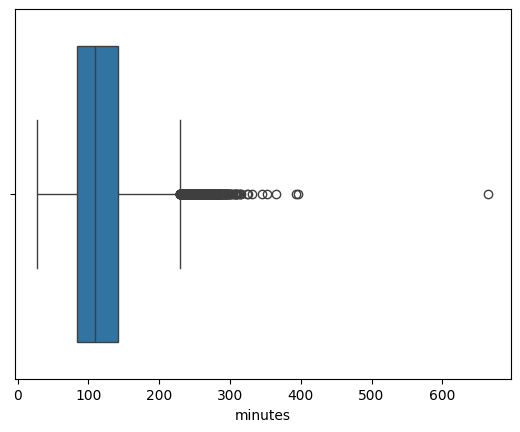

In [1165]:
sns.boxplot(x=train_data['minutes'])

<Axes: xlabel='variable', ylabel='value'>

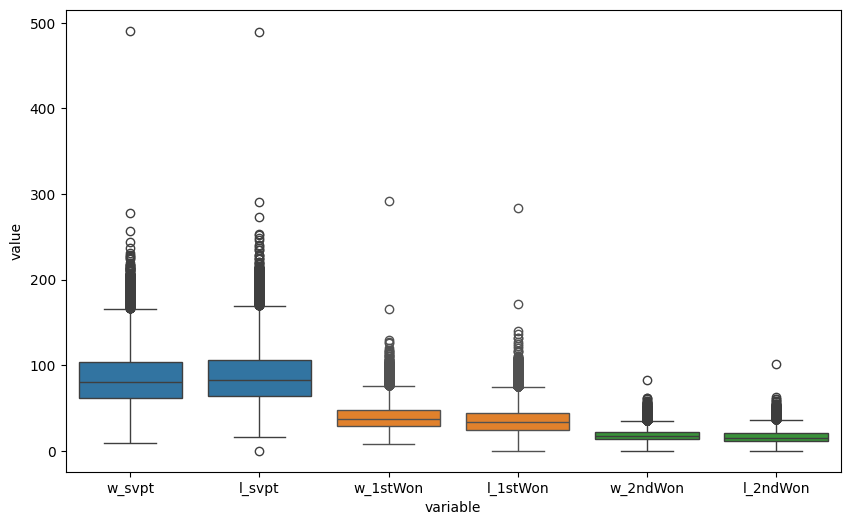

In [1166]:
fig, axes = plt.subplots(figsize=(10, 6))

sns.boxplot(x='variable', y='value', data=pd.melt(train_data[['w_svpt', 'l_svpt']]))
sns.boxplot(x='variable', y='value', data=pd.melt(train_data[['w_1stWon', 'l_1stWon']]))
sns.boxplot(x='variable', y='value', data=pd.melt(train_data[['w_2ndWon', 'l_2ndWon']]))

# 'w_svpt' = winner's number of serve points, 'w_1stWon' = winner's number of first-serve points won, 'w_2ndWon' = winner's number of second-serve points won

In [1167]:
# It's really visible that in all variables there is 1 main outlier. It is the longest match that was played during 2010 Wimbledon.
# I checked this data on the Internet and it's correct. I won't remove this match from data because it would affect column regarding
# fatigue during previous match that I will create later but I will take this knowledge into consideration while filling missing values.
train_data.nlargest(1, 'minutes')

,tourney_name,surface,tourney_level,tourney_date,match_num,winner_id,winner_entry,winner_hand,winner_ht,winner_ioc,...,w_1stWon,w_2ndWon,l_svpt,l_1stWon,l_2ndWon,winner_rank,winner_rank_points,loser_rank,loser_rank_points,source
52187,Wimbledon,Grass,G,2010-06-21,60,104545,NaN,R,206.0,USA,...,292.0,82.0,489.0,284.0,101.0,19.0,1925.0,148.0,339.0,train_data


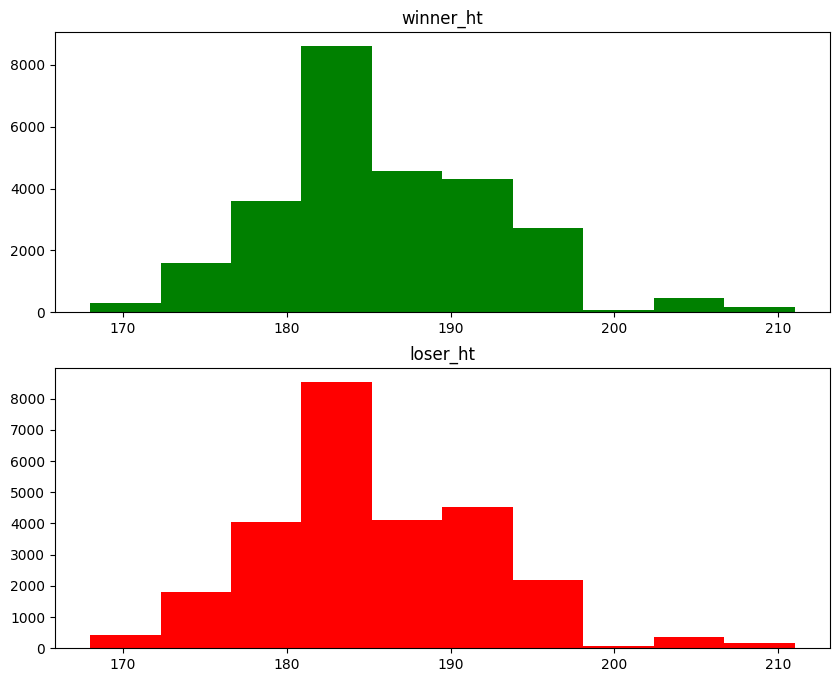

In [1168]:
# Comparing distribution of height.
fig, axes = plt.subplots(2, 1, figsize=(10, 8))
train_data['winner_ht'].hist(ax=axes[0], grid=False, color='green')
axes[0].set_title('winner_ht')
train_data['loser_ht'].hist(ax=axes[1], grid=False, color='red')
axes[1].set_title('loser_ht')
plt.show()

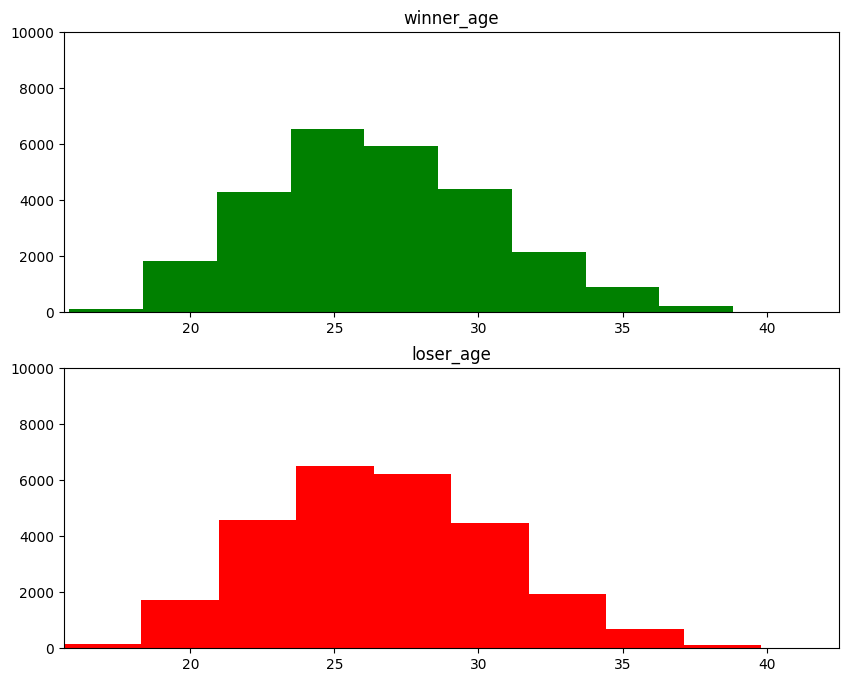

In [1169]:
# Comparing distribution of age.
fig, axes = plt.subplots(2, 1, figsize=(10, 8))
train_data['winner_age'].hist(ax=axes[0], grid=False, color='green')
axes[0].set_title('winner_age')
train_data['loser_age'].hist(ax=axes[1], grid=False, color='red')
axes[1].set_title('loser_age')

axes[0].set_xlim(min(train_data[['winner_age', 'loser_age']].min()), max(train_data[['winner_age', 'loser_age']].max()))
axes[1].set_xlim(min(train_data[['winner_age', 'loser_age']].min()), max(train_data[['winner_age', 'loser_age']].max()))
axes[0].set_ylim(0, 10000)
axes[1].set_ylim(0, 10000)
plt.show()

In [1170]:
# Age and height of a player doesn't seem to be a factor in determining a winner.
# But anyway I will try to build model with and without them and then decide whether to remove those features.

## Filling in missing values #1

In [1171]:
# Checking how many missing values there is.
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26463 entries, 52724 to 18982
Data columns (total 30 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   tourney_name        26463 non-null  object        
 1   surface             26463 non-null  object        
 2   tourney_level       26463 non-null  object        
 3   tourney_date        26463 non-null  datetime64[ns]
 4   match_num           26463 non-null  int64         
 5   winner_id           26463 non-null  int64         
 6   winner_entry        3316 non-null   object        
 7   winner_hand         26463 non-null  object        
 8   winner_ht           26392 non-null  float64       
 9   winner_ioc          26463 non-null  object        
 10  winner_age          26463 non-null  float64       
 11  loser_id            26463 non-null  int64         
 12  loser_entry         5733 non-null   object        
 13  loser_hand          26463 non-null  object     

In [1172]:
# Function to fill in missing values with average (this function has option of removing outliers before calculating average).
def fill_with_average(df, columns, count_of_outliers=0):
    for column_name in columns:
        column = df[column_name]
        outliers = column.nlargest(count_of_outliers)
        filler = round(column[~column.isin(outliers)].mean())
        df[column_name] = column.fillna(filler)

fill_with_average(train_data, ['winner_ht', 'loser_ht', 'loser_age'])

# For the purpose of calculating a better average, I am excluding the longest match.
fill_with_average(train_data, ['minutes', 'w_svpt', 'w_1stWon', 'w_2ndWon', 'l_svpt', 'l_1stWon', 'l_2ndWon'], count_of_outliers=1)


## Data engineering

In [1173]:
# List of tournaments to be mapped to countries:
print(train_data["tourney_name"].unique())

['Cincinnati Masters' 'Beijing' 'Indian Wells Masters' 'Rome Masters'
 'Roland Garros' 'Monte Carlo Masters' 'Madrid Masters' 'Paris Masters'
 'Acapulco' 'Australian Open' 'Wimbledon' 'Dubai' 'US Open' 'London'
 'Canada Masters' 'Stuttgart' 'Barcelona' 'Miami Masters'
 'Shanghai Masters' 'Memphis' 'Rotterdam' 'Basel' 'Halle' 'Kitzbuhel'
 'Tokyo' 'Hamburg Masters' 'Valencia' 'Washington' 'Indianapolis' 'Vienna'
 'Stuttgart Masters' 'Mexico City' 'Rio de Janeiro' 'Hamburg'
 'Stuttgart Outdoor' 'Astana' 'St. Petersburg']


In [1174]:
# Mapping tournaments to countries and creating new column that will be used to determine whether any of players has home advantage.
# It may be necessary to later go back and expand this dictionary by positions from test set.
ioc_mapping = {'Cincinnati Masters': 'USA',
               'Beijing': 'CHN',
               'Indian Wells Masters': 'USA',
               'Rome Masters': 'ITA',
               'Roland Garros': 'FRA',
               'Monte Carlo Masters': 'MON',
               'Madrid Masters': 'ESP',
               'Paris Masters': 'FRA',
               'Acapulco': 'MEX',
               'Australian Open': 'AUS',
               'Wimbledon': 'GBR',
               'Dubai': 'UAE',
               'US Open': 'USA',
               'London': 'GBR',
               'Canada Masters': 'CAN',
               'Stuttgart': 'GER',
               'Barcelona': 'ESP',
               'Miami Masters': 'USA',
               'Shanghai Masters': 'CHN',
               'Memphis': 'USA',
               'Rotterdam': 'NED',
               'Basel': 'SUI',
               'Halle': 'GER',
               'Kitzbuhel': 'AUT',
               'Tokyo': 'JPN',
               'Hamburg Masters': 'GER',
               'Valencia': 'ESP',
               'Washington': 'USA',
               'Indianapolis': 'USA',
               'Vienna': 'AUT',
               'Stuttgart Masters': 'GER',
               'Mexico City': 'MEX',
               'Rio de Janeiro': 'BRA',
               'Hamburg': 'GER',
               'Stuttgart Outdoor': 'GER',
               'Astana': 'KAZ',
               'St. Petersburg': 'RUS',
               'Antwerp': 'BEL',
               'Milan': 'ITA',
               'Philadelphia': 'USA',
               'New Haven': 'USA',
               'Singapore': 'SGP',
               }

def home_advantage_mapping(df):
    df.loc[:, 'tourney_ioc'] = df['tourney_name'].replace(ioc_mapping)

    # Assigning 1 to the player that has home advantage.
    df['home_adv_p1'] = 0
    df['home_adv_p2'] = 0
    df.loc[(df['winner_ioc'] == df['tourney_ioc']) & (df['winner_ioc'] != df['loser_ioc']), 'home_adv_p1'] = 1
    df.loc[(df['loser_ioc'] == df['tourney_ioc']) & (df['winner_ioc'] != df['loser_ioc']), 'home_adv_p2'] = 1
    df.drop(['winner_ioc', 'loser_ioc'], axis=1, inplace=True)

home_advantage_mapping(train_data)

In [1175]:
print(train_data['home_adv_p1'].value_counts())
print(train_data['home_adv_p2'].value_counts())

home_adv_p1
0    24016
1     2447
Name: count, dtype: int64
home_adv_p2
0    23657
1     2806
Name: count, dtype: int64


In [1176]:
# Checking options in used hand.
print(train_data['winner_hand'].value_counts())
print(train_data['loser_hand'].value_counts())

winner_hand
R    23234
L     3212
U       17
Name: count, dtype: int64
loser_hand
R    22893
L     3518
U       52
Name: count, dtype: int64


In [1177]:
# Function that creates 0/1 columns depending if there is the difference in the variable between 2 players. If it is the same then value = 0.
def create_columns_0_1(df, old_columns, prefix, condition, should_print=False):  
    for i in range(2):
        df[f'{prefix}_p{i+1}'] = 0
        filter_condition = (df[old_columns[i]].isin(condition) & (df[old_columns[0]] != df[old_columns[1]]))
        df.loc[filter_condition, f'{prefix}_p{i+1}'] = 1
        if should_print:
            print(df[f'{prefix}_p{i+1}'].value_counts())
    df.drop(old_columns, axis=1, inplace=True)

In [1178]:
# Creating columns depending on used hand. I assumed that players with Unknown hand use Rigt hand because it is far more likely.
# Left hand = 1 if only one player uses left hand.
create_columns_0_1(train_data, ['winner_hand', 'loser_hand'], 'hand', ['L'], True)

hand_p1
0    23671
1     2792
Name: count, dtype: int64
hand_p2
0    23365
1     3098
Name: count, dtype: int64


In [1179]:
# Checking options in entry.
print(train_data['winner_entry'].value_counts())
print(train_data['loser_entry'].value_counts())

winner_entry
Q      1997
WC      949
LL      279
PR       66
SE       23
ALT       1
Alt       1
Name: count, dtype: int64
loser_entry
Q      3374
WC     1714
LL      532
PR       79
SE       31
Alt       2
ALT       1
Name: count, dtype: int64


In [1180]:
# 'Q' = qualifier, 'WC' = wild card, 'LL' = lucky loser, 'ITF' = ITF entry, 'SE' = special exempt
# Mapping Q and LL as 1 and the rest as 0. Only those 2 options really matter because they can indicate additional fatigue of a player
# because of the extra matches in elimination to the tournament.
create_columns_0_1(train_data, ['winner_entry', 'loser_entry'], 'entry', ['Q', 'LL'], True)

entry_p1
0    24443
1     2020
Name: count, dtype: int64
entry_p2
0    22813
1     3650
Name: count, dtype: int64


In [1181]:
# Duplicating DataFrame with switched order and concatinating it together. It is necessary for 2 reasons:
# to determine cumulative numbers for each player and to add labels 1/0 that are needed in supervised learning.

# Changing column names from winner/loser to p1/p2 because old names wouldn't make sense anymore.
def change_prefix(name):
    if name.startswith('winner_') or name.startswith('w_'):
        return name.split('_', 1)[1] +'_p1'
    elif name.startswith('loser_') or name.startswith('l_'):
        return name.split('_', 1)[1] +'_p2'
    else:
        return name

# Switching order of columns.
def change_places(names):
    for i in range(len(names)):
        if names[i][-3:] == '_p1':
            for j in range(i + 1, len(names)):
                if names[i][:-3] == names[j][:-3] and names[j][-3:] == '_p2':
                    names[i], names[j] = names[j], names[i]
    return names

def duplicate_and_add_labels(df):
    # DataFrame for wins.
    modified_column_names = [change_prefix(name) for name in df.columns]    
    df_wins = df.copy()
    df_wins.columns = modified_column_names

    # Dataframe for losses.
    switched_column_names = change_places(modified_column_names.copy())
    df_losses = df_wins.copy()[switched_column_names]
    df_losses.columns = modified_column_names

    # Adding labels and connecting DataFrames together.
    df_wins['result'] = 1
    df_losses['result'] = 0
    atp_with_labels = pd.concat([df_wins, df_losses])
    return atp_with_labels

train_data = duplicate_and_add_labels(train_data)

In [1182]:
# Defining constants that will be used to determine moving window in creation of features.
# I tested different moving windows for different features.
YEARS = 5
YEARS_FOR_PTS = 3
DAYS = 365 * YEARS
DAYS_FOR_PTS = 365 * YEARS_FOR_PTS
BASIC_MINIMUM_MATCHES = 8

# For this step datasets needs to be concatenated back together.
# First, the previous functions need to be executed on additional_data and test_data so the column names would match.
# I'm not looking at any of the results from those 2 sets so data leakage is avoided (they weren't used in data exploration
# and their missing values were filled in separately).
tourneys_mapping(test_data)
tourneys_mapping(additional_data)
atp_500_mapping(test_data)
atp_500_mapping(additional_data)
test_data = remove_rows_cols(test_data)
additional_data = remove_rows_cols(additional_data)
fill_with_average(test_data, ['winner_ht', 'loser_ht', 'loser_age'])
fill_with_average(additional_data, ['winner_ht', 'loser_ht', 'loser_age'])
fill_with_average(test_data, ['minutes', 'w_svpt', 'w_1stWon', 'w_2ndWon', 'l_svpt', 'l_1stWon', 'l_2ndWon'])
fill_with_average(additional_data, ['minutes', 'w_svpt', 'w_1stWon', 'w_2ndWon', 'l_svpt', 'l_1stWon', 'l_2ndWon'])
home_advantage_mapping(test_data)
home_advantage_mapping(additional_data)
create_columns_0_1(test_data, ['winner_hand', 'loser_hand'], 'hand', ['L'])
create_columns_0_1(additional_data, ['winner_hand', 'loser_hand'], 'hand', ['L'])
create_columns_0_1(test_data, ['winner_entry', 'loser_entry'], 'entry', ['Q', 'LL'])
create_columns_0_1(additional_data, ['winner_entry', 'loser_entry'], 'entry', ['Q', 'LL'])
test_data = duplicate_and_add_labels(test_data)
additional_data = duplicate_and_add_labels(additional_data)

# Concatenating datasets.
full_data = pd.concat([additional_data, train_data, test_data])

# Sorting matches chronologically and changing index to tourney_date (necessary to rolling function).
full_data.sort_values(by=['tourney_date', 'match_num'], inplace=True)
full_data.set_index('tourney_date', inplace=True)

# Function to aggregate data to achieve counts of wins, matches and different statistics per player for the chosen period of time (constant YEARS).
# It is very important not to include current row in rolling function and this is why '1' or 'group' needs to be subtracted from the result 
# depending on aggregation type. I am not using (closed='left') parameter in rolling because there are duplicates in dates and doing so would 
# result in not inluding data from the whole current tournament. Data doesn't include specific dates of matches only dates of starting the tournament. 
# This is why I chose the method with subtracting.
def aggregate_group(df, agg_column_name, grouping_columns, agg_func='sum', days = DAYS, minimum=0, min_column=False):
    grouped_data = df.groupby(grouping_columns)[agg_column_name]
    if agg_func == 'sum':
        result = grouped_data.transform(lambda group: group.rolling(window=f'{days}D').sum() - group)
    elif agg_func == 'count':
        result = grouped_data.transform(lambda group: group.rolling(window=f'{days}D').count() - 1)
    # Filling in None values if the condition of minimum count of matches isn't met. It is important for ratio because it would be skewed without 
        # this condition. For example if the player would lost 1 out of 1 matches played it would be 0 and it would be the same for algorithm as 
        # losing 5 out of 5 matches which really tells much more about player's performance. Such cases will be later filled in with average.
    if min_column:
        result[df[min_column] < minimum] = np.nan
    return result

# Function to count wins, matches and ratio per player at the same time.
def create_ratio_features(df, agg_column, additional_group_column=None, prefix='', min=BASIC_MINIMUM_MATCHES):
    # Determining grouping columns.
    grouping_columns = [[f'id_p{i}', additional_group_column] if additional_group_column else f'id_p{i}' for i in range(1, 3)]
    
    df[f'{prefix}matches_{YEARS}yrs_p1'] = aggregate_group(df, agg_column, grouping_columns[0], 'count')
    df[f'{prefix}wins_{YEARS}yrs_p1'] = aggregate_group(df, agg_column, grouping_columns[0], minimum=min, 
                                                        min_column=f'{prefix}matches_{YEARS}yrs_p1')
    df[f'{prefix}ratio_{YEARS}yrs_p1'] = df[f'{prefix}wins_{YEARS}yrs_p1'] / df[f'{prefix}matches_{YEARS}yrs_p1']
    df[f'{prefix}matches_{YEARS}yrs_p2'] = aggregate_group(df, agg_column, grouping_columns[1], 'count')
    df[f'{prefix}losses_{YEARS}yrs_p2'] = aggregate_group(df, agg_column, grouping_columns[1], minimum=min, 
                                                          min_column=f'{prefix}matches_{YEARS}yrs_p2')
    df[f'{prefix}wins_{YEARS}yrs_p2'] = df[f'{prefix}matches_{YEARS}yrs_p2'] - df[f'{prefix}losses_{YEARS}yrs_p2']
    df[f'{prefix}ratio_{YEARS}yrs_p2'] = df[f'{prefix}wins_{YEARS}yrs_p2'] / df[f'{prefix}matches_{YEARS}yrs_p2']

# General wins' ratio per x years (without any additional conditions).
create_ratio_features(full_data, 'result', min=BASIC_MINIMUM_MATCHES)

# Summing won points per match per player and calculating ratios per chosen period of time. I haven't decided yet on this stage whether I will be using 
# won points in general or won serve points and won returns. This is why I've created both of these columns. I will decide which option to choose after
# trials on machine learning models.
def create_pts_features(df):
    df[f'pts_played'] = df[f'svpt_p1'] + df[f'svpt_p2']

    for i in range(1, 3):
        df[f'won_svpt_p{i}'] = df[f'1stWon_p{i}'] + df[f'2ndWon_p{i}']

    j = 2 # It's needed to correctly calculate won returns and ratio of returns.
    for i in range(1, 3):
        df[f'matches_{YEARS_FOR_PTS}yrs_p{i}'] = aggregate_group(df, 'result', f'id_p{i}', 'count', days=DAYS_FOR_PTS)
        df[f'won_returns_p{i}'] = df[f'svpt_p{j}'] - df[f'won_svpt_p{j}']
        df[f'pts_won_p{i}'] = df[f'won_svpt_p{i}'] + df[f'won_returns_p{i}']
        df[f'ratio_svpt_{YEARS_FOR_PTS}yrs_p{i}'] = aggregate_group(df, f'won_svpt_p{i}', f'id_p{i}', days=DAYS_FOR_PTS, minimum=BASIC_MINIMUM_MATCHES, 
                                                            min_column=f'matches_{YEARS_FOR_PTS}yrs_p{i}') / aggregate_group(df, f'svpt_p{i}', f'id_p{i}', days=DAYS_FOR_PTS)
        df[f'ratio_returns_{YEARS_FOR_PTS}yrs_p{i}'] = aggregate_group(df, f'won_returns_p{i}', f'id_p{i}', days=DAYS_FOR_PTS, minimum=BASIC_MINIMUM_MATCHES, 
                                                               min_column=f'matches_{YEARS_FOR_PTS}yrs_p{i}') / aggregate_group(df, f'svpt_p{j}', f'id_p{i}', days=DAYS_FOR_PTS)
        df[f'ratio_pts_{YEARS_FOR_PTS}yrs_p{i}'] = aggregate_group(df, f'pts_won_p{i}', f'id_p{i}', days=DAYS_FOR_PTS, minimum=BASIC_MINIMUM_MATCHES, 
                                                           min_column=f'matches_{YEARS_FOR_PTS}yrs_p{i}') / aggregate_group(df, f'pts_played', f'id_p{i}', days=DAYS_FOR_PTS)
        j -= 1

create_pts_features(full_data)

In [1183]:
# Checking options in the surface.
print(train_data['surface'].value_counts())

surface
Hard      31642
Clay      15846
Grass      4954
Carpet      484
Name: count, dtype: int64


In [1184]:
# Carpet surface is very small in number. Looking for the reason. Checking when the last tournament took place on this surface.
train_data.loc[train_data['surface'] == 'Carpet'].index.max()

38622

In [1185]:
# Last tournament on carpet took place in 30.10.2006 so it makes sense that it is much lower in quantity.
# Comparing players' performance (wins' ratio) on every surface to check which one provides advantage to specific player.
# I chose lower minimum than in case of general matches (half of it).
create_ratio_features(full_data, 'result', additional_group_column='surface', prefix='surface_', min=BASIC_MINIMUM_MATCHES/2)

In [1186]:
# Direct matches of 2 players per x years. Direct matches between players are far more rare so I set minimum to 3 because it 
# already says something.
def create_direct_features(df):
    df[f'direct_matches_{YEARS}yrs'] = aggregate_group(df, 'result', ['id_p1', 'id_p2'], 'count')
    df[f'direct_wins_{YEARS}yrs_p1'] = aggregate_group(df, 'result', ['id_p1', 'id_p2'], minimum=3, 
                                                       min_column=f'direct_matches_{YEARS}yrs')
    df[f'direct_wins_{YEARS}yrs_p2'] = df[f'direct_matches_{YEARS}yrs'] - df[f'direct_wins_{YEARS}yrs_p1']

    df[f'direct_ratio_{YEARS}yrs_p1'] = df[f'direct_wins_{YEARS}yrs_p1'] / df[f'direct_matches_{YEARS}yrs']
    df[f'direct_ratio_{YEARS}yrs_p2'] = 1 - df[f'direct_ratio_{YEARS}yrs_p1']

create_direct_features(full_data)

In [1187]:
# Checking options in 'round'.
print(train_data['round'].value_counts())

round
R64     15048
R32     13516
R128    11566
R16      6802
QF       3440
SF       1706
F         848
Name: count, dtype: int64


In [1188]:
# Because lower rounds like R64 and R128 may not even appear in many tournaments and in some tournaments some players start 
# competition even on R16, I consider minimum getting to QF as achievement in specific tournament. So tournaments will be 
# considered as conducive for the player if he got to round QF or higher in previous x years.
rounds_mapping = {'QF': 1, 'SF': 1, 'F': 1}

def create_tourney_adv(df):
    df['round_pts'] = df['round'].map(lambda x: rounds_mapping.get(x, 0))
    # Sum will give 3 points for F, 2 points for SF and 1 point for QF. This time I'm using (closed='left') parameter in rolling 
    # so players won't get points for currently played tournament.
    for i in range(1, 3):
        df[f'tourney_{YEARS}yrs_p{i}'] = df.groupby([f'id_p{i}', 'tourney_name'])['round_pts'].transform(
            lambda group: group.rolling(window=f'{365*YEARS}D', closed='left').sum())
        
create_tourney_adv(full_data)

In [1189]:
MATCHES = 3
MONTHS = 3

# Rating players' performance in the last x months with minimum of x matches. Both by ELO rating and number of matches won/played.
def create_last_mths_performance(df):
    # Calculating change in ELO rating for every match considering ATP ranking points as the starting point.
    result = df['result']
    ranking_p1 = df['rank_points_p1']
    ranking_p2 = df['rank_points_p2']
    # Formula to calculate change in ELO rating.
    df['elo_change_p1'] = 20 * (result - (1 / (1 + 10 ** ((ranking_p2 - ranking_p1) / 400))))
    df['elo_change_p2'] = - df['elo_change_p1']
    # ELO rating.
    for i in range(1, 3):
        df[f'{MONTHS}_mths_matches_p{i}'] = aggregate_group(df, 'result', f'id_p{i}', 'count', days=30*MONTHS)
        df[f'{MONTHS}_mths_elo_p{i}'] = aggregate_group(df, f'elo_change_p{i}', f'id_p{i}', days=30*MONTHS, 
                                                        minimum=MATCHES, min_column=f'{MONTHS}_mths_matches_p{i}')
    # Matches won/played.
    df[f'{MONTHS}_mths_wins_p1'] = aggregate_group(df, 'result', 'id_p1', days=30*MONTHS, minimum=MATCHES, 
                                                   min_column=f'{MONTHS}_mths_matches_p1')
    df[f'{MONTHS}_mths_losses_p2'] = aggregate_group(df, 'result', 'id_p2', days=30*MONTHS, minimum=MATCHES, 
                                                     min_column=f'{MONTHS}_mths_matches_p2')
    df[f'{MONTHS}_mths_wins_p2'] = df[f'{MONTHS}_mths_matches_p2'] - df[f'{MONTHS}_mths_losses_p2']

create_last_mths_performance(full_data)

In [1190]:
# Finding duration of the previous match played in the current tournament - it will indicate fatigue of the players.
# If there is no previous match then 0 minutes.
def create_fatigue_feature(df):
    df.reset_index(inplace=True)
    for i in range(1, 3):
        df[f'previous_minutes_p{i}'] = df.groupby([f'id_p{i}', 'tourney_date'])['minutes'].shift().fillna(0)
        
create_fatigue_feature(full_data)

In [1191]:
DAYS_OF_BRAKE = 120

# Return after the brake: possible injury or weak performance in previous months that resulted in not qualifying the player to main tournament.
# The first match after such brake could result in different performance.
# Number of days between matches can also be a valuable information.
def create_had_brake_feature(df):
    for i in range(1, 3):
        df[f'how_long_brake_p{i}'] = df.groupby(f'id_p{i}')['tourney_date'].diff().dt.days
        df[f'had_brake_p{i}'] = (df[f'how_long_brake_p{i}'] > DAYS_OF_BRAKE).astype('int64')

    # If both players had brake then it doesn't matter and the value should be set to 0.
    df.loc[(df['had_brake_p1'] == df['had_brake_p2']), ['had_brake_p1', 'had_brake_p2']] = 0

create_had_brake_feature(full_data)

## Splitting dataset again and removing unnecessary columns

In [1192]:
# Datasets need to be split again before filling in missing values to prevent data leakage.
# Additional data from years 1995-1999 won't be needed anymore.

In [1193]:
# Removig matches before from 3 years that were used only to generate x yrs features but won't be used in the learning process.
# For train set those are matches before 01.01.2000.
def remove_x_years(df, end_date):
    df['tourney_date'] = pd.to_datetime(df['tourney_date'])
    df.drop(df[df['tourney_date'] <= end_date].index, inplace=True)

remove_x_years(train_data, '1999-12-31')

train_data = full_data.loc[full_data['source'] == 'train_data', :]
test_data = full_data.loc[full_data['source'] == 'test_data', :]

In [1194]:
# Checking what columns are available after data engineering.
train_data.columns

Index(['tourney_date', 'tourney_name', 'surface', 'tourney_level', 'match_num',
       'id_p1', 'ht_p1', 'age_p1', 'id_p2', 'ht_p2', 'age_p2', 'round',
       'minutes', 'svpt_p1', '1stWon_p1', '2ndWon_p1', 'svpt_p2', '1stWon_p2',
       '2ndWon_p2', 'rank_p1', 'rank_points_p1', 'rank_p2', 'rank_points_p2',
       'source', 'tourney_ioc', 'home_adv_p1', 'home_adv_p2', 'hand_p1',
       'hand_p2', 'entry_p1', 'entry_p2', 'result', 'matches_5yrs_p1',
       'wins_5yrs_p1', 'ratio_5yrs_p1', 'matches_5yrs_p2', 'losses_5yrs_p2',
       'wins_5yrs_p2', 'ratio_5yrs_p2', 'pts_played', 'won_svpt_p1',
       'won_svpt_p2', 'matches_3yrs_p1', 'won_returns_p1', 'pts_won_p1',
       'ratio_svpt_3yrs_p1', 'ratio_returns_3yrs_p1', 'ratio_pts_3yrs_p1',
       'matches_3yrs_p2', 'won_returns_p2', 'pts_won_p2', 'ratio_svpt_3yrs_p2',
       'ratio_returns_3yrs_p2', 'ratio_pts_3yrs_p2', 'surface_matches_5yrs_p1',
       'surface_wins_5yrs_p1', 'surface_ratio_5yrs_p1',
       'surface_matches_5yrs_p2', 'su

In [1195]:
# Leaving only columns that are useful in ML. 
necessary_columns = ['result', 'ht_p1', 'age_p1', 'ht_p2', 'age_p2', 'rank_points_p1', 'rank_points_p2', 'home_adv_p1', 'home_adv_p2',
                      'hand_p1', 'hand_p2', 'entry_p1', 'entry_p2', f'matches_{YEARS}yrs_p1', f'wins_{YEARS}yrs_p1', f'ratio_{YEARS}yrs_p1',
                      f'matches_{YEARS}yrs_p2', f'wins_{YEARS}yrs_p2', f'ratio_{YEARS}yrs_p2', f'ratio_svpt_{YEARS_FOR_PTS}yrs_p1',
                      f'ratio_returns_{YEARS_FOR_PTS}yrs_p1', f'ratio_pts_{YEARS_FOR_PTS}yrs_p1', f'ratio_svpt_{YEARS_FOR_PTS}yrs_p2',
                      f'ratio_returns_{YEARS_FOR_PTS}yrs_p2', f'ratio_pts_{YEARS_FOR_PTS}yrs_p2', f'surface_matches_{YEARS}yrs_p1',
                      f'surface_wins_{YEARS}yrs_p1', f'surface_ratio_{YEARS}yrs_p1', f'surface_matches_{YEARS}yrs_p2',  f'surface_wins_{YEARS}yrs_p2',
                      f'surface_ratio_{YEARS}yrs_p2', f'direct_wins_{YEARS}yrs_p1', f'direct_ratio_{YEARS}yrs_p1', f'direct_wins_{YEARS}yrs_p2',
                      f'direct_ratio_{YEARS}yrs_p2', f'tourney_{YEARS}yrs_p1', f'tourney_{YEARS}yrs_p2', f'{MONTHS}_mths_matches_p1',
                      f'{MONTHS}_mths_elo_p1', f'{MONTHS}_mths_matches_p2', f'{MONTHS}_mths_elo_p2', f'{MONTHS}_mths_wins_p1', f'{MONTHS}_mths_wins_p2',
                      'previous_minutes_p1', 'previous_minutes_p2', 'how_long_brake_p1', 'how_long_brake_p2', 'had_brake_p1', 'had_brake_p2']

train_data = train_data[necessary_columns]
test_data = test_data[necessary_columns]

## Filling in missing values #2

In [1196]:
# Checking how many missing values there is in newly created features.
print(train_data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 52926 entries, 14696 to 80829
Data columns (total 49 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   result                   52926 non-null  int64  
 1   ht_p1                    52926 non-null  float64
 2   age_p1                   52926 non-null  float64
 3   ht_p2                    52926 non-null  float64
 4   age_p2                   52926 non-null  float64
 5   rank_points_p1           52926 non-null  float64
 6   rank_points_p2           52926 non-null  float64
 7   home_adv_p1              52926 non-null  int64  
 8   home_adv_p2              52926 non-null  int64  
 9   hand_p1                  52926 non-null  int64  
 10  hand_p2                  52926 non-null  int64  
 11  entry_p1                 52926 non-null  int64  
 12  entry_p2                 52926 non-null  int64  
 13  matches_5yrs_p1          52926 non-null  float64
 14  wins_5yrs_p1           

In [1197]:
# If any of 2 players in a match is missing value in the specific column based on the previous matches then both players will be filled in 
# with average of the whole column so this specific feature wouldn't take part in predicting the winner of the specific match.

def fill_missing_features(df):
    # First I give None value for such pair. I skip columns of int type because there are no missing values in these columns and because np.nan
    # would change their dtype.
    for column, dtype in df.dtypes.items():
        if column[-1:] in['1', '2'] and dtype != 'int64':
            prefix = column[:-1]
            twin_column = (prefix + '1') if column[-1:] == '2' else (prefix + '2')
            df.loc[df[column].isna(), twin_column] = np.nan
    # Then I fill it in with average.
    for column, dtype in df.dtypes.items():
        if dtype != 'int64':
            df.loc[df[column].isna(), column] = df[column].mean()

fill_missing_features(train_data)
fill_missing_features(test_data)

In [1198]:
# There is one more thing left to do in data engineering.
# Using ML algorithm on such list of features would cause the model to be asymmetric. As a result, for example feature 'home_adv_p1' could
# be 0.05 and analogous 'home_adv_p2' could be equal to -0.06. It results in a problem because such model could perform better or worse 
# depeding on the order of the players put into equation. The simplest way to resolve this problem is to replace old features with new ones
# that will be equal to the difference of old features. Such approach has 2 benefits: it's symmetric and it reduces number of features by half
# so training algorithm will be much faster.
def subtract_features(df):
    for column in df.columns:
        prefix = column[:-1]
        twin_column =  f'{prefix}2'
        if column[-1:] == '1':
            df[f'{prefix}12'] = df[column] - df[twin_column]
            df.drop([column, twin_column], axis=1, inplace=True)

subtract_features(train_data)
subtract_features(test_data)

# Making sure that the final sizes of test and train sets are in 80-20 ratio.
print(train_data.shape)
print(test_data.shape)

(52926, 25)
(13208, 25)


In [1199]:
# Saving clean train and test datasets to files.
train_data.to_csv('../data/03_processed_data/clean_train_data.csv', index=False)
test_data.to_csv('../data/03_processed_data/clean_test_data.csv', index=False)